In [1]:
import os
import time
import pandas as pd
import numpy as np
import geopandas as gpd
import planetary_computer as pc
import rioxarray as rioxr

import rasterio as rio
from rasterio.crs import CRS

from shapely.geometry import box

from skimpy import clean_columns

import raster_to_features as rf
import data_sampling_workflow.sample_rasters as sr

In [2]:
year = 2020

In [3]:
# convert reference class columns in df from CollectEarth 
# into a single ref_class column with values from 0 to 3
def ref_class_column(df):

    map_class = df.pl_class
    ref_class = []

    for i in map_class.index:
        if df.category_non_iceplant_vegetation.loc[i] == 100:
            ref_class.append(0)
        elif df.category_iceplant.loc[i] == 100:
            ref_class.append(1)
        elif df.category_low_ndvi_impervious_surface.loc[i] == 100:
            ref_class.append(2)
        elif df.category_water.loc[i] == 100:
            ref_class.append(3)
        else:
            ref_class[j]= 100
            
    return ref_class

# ---------------------------------------------------------------
# make dictionary with points that need to be sampled from each scene
def split_by_scene(pts, footprints):
    
    unchecked = list(pts.index)
    pts_to_sample = {key: [] for key in footprints.id}

    for itemid in footprints.id:
        box = list(footprints[footprints.id == itemid].geometry)[0]

        to_remove = []
        for i in unchecked:
            point = pts.iloc[i].geometry
            if box.contains(point) == True:
                pts_to_sample[itemid].append(i)
                to_remove.append(i)

        for i in to_remove:
            unchecked.remove(i)
    return pts_to_sample

In [4]:
# ---------------------------------------------------
# load validation points
fp = os.path.join(os.getcwd(), 'map_validation', 'validation_results_'+str(year)+'.csv' )
validation_pts = clean_columns(sr.geodataframe_from_csv(fp = fp, 
                                                        lon_label = 'center_lon', 
                                                        lat_label = 'center_lat', 
                                                        crs = CRS.from_epsg(4326)))

# clean data frame 
validation_pts['ref_class'] = ref_class_column(validation_pts)
validation_pts = validation_pts.drop(['center_lon', 'center_lat', 'shape', 'size_m', 'sample_points',
        'flagged', 'flagged_reason',  
         'total_securewatch_dates', 'common_securewatch_date', 
         'validation_finished_yes_high_confidence',
         'collection_time',
         'category_low_ndvi_impervious_surface','category_non_iceplant_vegetation',
         'category_iceplant', 'category_water', 'plotid'], axis =1)
validation_pts = validation_pts.rename( 
    columns = {'pl_class':'map_class',
               'validation_finished_no_low_confidence':'low_confidence'})

# ---------------------------------------------------
# load NAIP scenes' footprints
footprints = gpd.read_file(os.path.join(os.getcwd(), 
                                        'separating_naip_flights',
                                        'naip_scenes_footprints',
                                        'naip_scenes_footprints.shp'))
footprints = footprints[footprints.year == str(year)]
footprints.reset_index(inplace=True, drop = True)

6 column names have been cleaned

In [5]:
# ---------------------------------------------------
# temporary folder for aux rasters
folp = os.path.join(os.getcwd(),'temp','aux_naip_rasters')
if os.path.exists(folp) == False:
    os.mkdir(folp)

# ---------------------------------------------------
# create auxiliary canopy height rasters: min, max, and avg 
lidar_fps = rf.create_aux_canopyheight_rasters(year)

# make dictionary with points that need to be sampled from each scene
pts_to_sample = split_by_scene(validation_pts, footprints)

In [7]:
# ---------------------------------------------------
sampled_points = []
#for itemid in samples:
for itemid in ['ca_m_3412037_nw_10_060_20200607']:
    if len(pts_to_sample[itemid]) > 0:
        
        to_sample = validation_pts.iloc[pts_to_sample[itemid]].geometry
        
        # ---------------------------------------------------
        # sample canopy height at point, and max, min and avg canopy height around point        
        canopy_h_samples = []
        for i, tag in zip(range(4),['', '_max', '_min', '_avg']):
            aux_rast_r = rio.open(lidar_fps[i])
            canopy_h_samples.append(sr.sample_raster_from_pts(to_sample, aux_rast_r, ['lidar'+tag]))        
        
        # ---------------------------------------------------        
        # sample spectral bands from NAIP
        item = sr.get_item_from_id(itemid)
        scene_rast_r = sr.get_raster_from_item(item)     

        band_names = ['r', 'g', 'b', 'nir']
        spectral_bands = sr.sample_raster_from_pts(to_sample, scene_rast_r, band_names).set_index(to_sample.index)

        # ---------------------------------------------------        
        # ---------------------------------------------------        
        # sample max, min, avg and entrs from NAIP
        to_sample_match = to_sample.to_crs(scene_rast_r.crs)
        scene_rast = rioxr.open_rasterio(pc.sign(item.assets["image"].href)) 
    
        band_names.append('ndvi')
        tags = ['_max', '_min', '_avg', '_entr']
        window_cols = [band+tag for band in band_names for tag in tags]        

        window_features = []
        for i in range(len(to_sample_match)):
            pt = to_sample_match.iloc[[i]]
            # clip scene to box around point
            reduce_box = box(*(pt.iloc[0].buffer(6).bounds)) 
            rast = scene_rast.rio.clip_box(*reduce_box.bounds)
            
            # save auxiliary rasters for R,G,B,NIR: max,min,avg,entr
            for i in range(4):
                sr.max_min_avg_rasters(raster=rast, band=i+1, rast_name=band_names[i], n=3, folder_path=folp)
                sr.entropy_raster(raster=rast, band=i+1, rast_name=band_names[i], n=3, folder_path=folp)
            # ------------------------------
            # make auxiliary NDVI of clipped scene
            ndvi = sr.ndvi_xarray(rast)

            # save auxiliary NDVI rasters: max,min,avg
            sr.max_min_avg_rasters(rast_data=ndvi, 
                                   crs=rast.rio.crs, 
                                   transf=rast.rio.transform(), 
                                   rast_name=band_names[4], 
                                   n=3, 
                                   folder_path=folp)
            
            # adjust ndvi to entropy input types
            ndvi = ndvi*100 +100
            sr.entropy_raster(rast_data=ndvi.astype('uint8'), 
                              crs=rast.rio.crs, transf=rast.rio.transform(), 
                              rast_name=band_names[4], 
                              n=3, 
                              folder_path=folp)
            # ---------------------------------------
            # sample raster values for current point
            samples = []
            for col_name in window_cols:
                fp = os.path.join(folp, col_name+'s.tif')
                aux_rast_r = rio.open(fp)
                sample = sr.sample_raster_from_pts(pt, aux_rast_r, [col_name])    
                os.remove(fp)
                samples.append(sample)       
                
            # ---------------------------------------
            # Add all derived spectral data to pts dataframe
            window_features.append(pd.concat(samples, axis = 1)) 
            
        # ---------------------------------------------------
        # concatenate sampled data
        window_features = pd.concat(window_features).set_index(to_sample_match.index)
        lidar_bands = pd.concat(canopy_h_samples, axis=1).set_index(to_sample.index)
        df = pd.concat([to_sample, spectral_bands, lidar_bands, window_features], axis=1)
      
        # ---------------------------------------------------
        # add date and naipid information
        kwargs = {'year' : item.datetime.year,
                  'month' : item.datetime.month,
                  'day_in_year' : sr.day_in_year(item.datetime.day, item.datetime.month, item.datetime.year),
                  'naip_id' : itemid}
        df = df.assign(**kwargs)
                
        # ---------------------------------------------------
        sampled_points.append(gpd.GeoDataFrame(df))

In [8]:
samples = pd.concat(sampled_points).sort_index()

samples = pd.concat([samples, validation_pts.drop(['geometry'], axis=1)], axis=1)

samples = samples[['geometry', 
 'r', 'g', 'b', 'nir', 
 'lidar', 'lidar_max', 'lidar_min', 'lidar_avg', 
 'year', 'month', 'day_in_year', 
 'naip_id', 'pl_which_raster',
 'email', 'analysis_duration','low_confidence',
  'map_class', 'ref_class']]

samples

,geometry,r,g,b,nir,lidar,lidar_max,lidar_min,lidar_avg,year,month,day_in_year,naip_id,pl_which_raster,email,analysis_duration,low_confidence,map_class,ref_class
8,POINT (-120.47411 34.45362),211.0,211.0,210.0,159.0,-9999.0,-9999.0,-9999.0,-2717.222168,2020.0,6.0,159.0,ca_m_3412037_nw_10_060_20200607,0,galaz-garcia@nceas.ucsb.edu,5.8 secs,0.0,2,3
12,POINT (-120.46838 34.45008),135.0,98.0,78.0,161.0,0.0,0.0,0.0,0.000000,2020.0,6.0,159.0,ca_m_3412037_nw_10_060_20200607,0,galaz-garcia@nceas.ucsb.edu,7.0 secs,0.0,1,1
18,POINT (-120.45116 34.44341),61.0,68.0,80.0,14.0,-9999.0,-9999.0,-9999.0,-2717.222168,2020.0,6.0,159.0,ca_m_3412037_nw_10_060_20200607,0,galaz-garcia@nceas.ucsb.edu,5.9 secs,0.0,3,3
30,POINT (-120.46747 34.45950),110.0,84.0,75.0,137.0,0.0,0.0,0.0,0.000000,2020.0,6.0,159.0,ca_m_3412037_nw_10_060_20200607,0,brun@nceas.ucsb.edu,9.5 secs,0.0,1,1
35,POINT (-120.47336 34.45746),139.0,125.0,101.0,73.0,-9999.0,0.0,-9999.0,615.777771,2020.0,6.0,159.0,ca_m_3412037_nw_10_060_20200607,0,brun@nceas.ucsb.edu,13.2 secs,0.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,galaz-garcia@nceas.ucsb.edu,6.3 secs,0.0,0,0
461,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,galaz-garcia@nceas.ucsb.edu,4.7 secs,0.0,2,2
462,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,galaz-garcia@nceas.ucsb.edu,10.8 secs,0.0,0,0
463,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,galaz-garcia@nceas.ucsb.edu,10.3 secs,0.0,2,0


In [ ]:
folder = os.path.join(os.getcwd(), 
                      'validation_augmented_spectral_'+str(year))
if os.path.exists(folder) == False:
    os.mkdir(folder)

samples.to_file(os.path.join(folder, 'validation_augmented_spectral_'+str(year))+'.shp')

In [ ]:
# ***************************************************
# ************* NOTEBOOK VARIABLES ******************

#itemids = pd.read_csv(os.path.join(os.getcwd(),'temp', 'aoi_naip_itemids.csv')).itemid

#csv_name = 'test_set.csv'
df = gpd.read_file(os.path.join(os.getcwd(), 'validation_results_spectral_2020', 'validation_results_spectral_2020.shp'))
itemids = list(df.naip_id.unique())
# ***************************************************

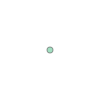

In [43]:
pt